In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import sys
from sklearn import linear_model

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression

from __future__ import division

from sklearn.linear_model import LinearRegression

In [2]:
prop = pd.read_csv('/home/pranay/Downloads/zillow/properties_2016.csv')
# prop = pd.read_csv('/home/blackstone/portfolio/zillow/properties_2016.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train = pd.read_csv('/home/pranay/Downloads/zillow/train_2016.csv')

In [ ]:
df_train = train.merge(prop, how='left', on='parcelid')

In [ ]:
df_train.columns

In [7]:
def checkNull(cols):
    for column in cols:
        perc = df_train[column].isnull().value_counts(normalize=True)[0]*100
        print "%f percent non-null values in column %s"%(perc, column)

In [ ]:
df_train.apply(lambda x: x.isnull().value_counts(normalize=True)[0]).sort_values()

In [463]:
# df_train['target'] = df_train.logerror.apply(lambda x: x > 0)

In [9]:
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode', 'rawcensustractandblock', 'propertyzoningdesc', 'regionidzip', 'censustractandblock'], axis =1)

In [10]:
object_columns = x_train.dtypes[x_train.dtypes == object].index
float_columns = x_train.dtypes[x_train.dtypes == 'float64'].index

count_columns = x_train[float_columns].filter(like='cnt').columns
id_columns = x_train[float_columns].filter(like='id').columns
feet_columns = x_train[float_columns].filter(like='feet').columns
sqft_columns = x_train[float_columns].filter(like = 'sqft').columns

In [ ]:
[column for column in float_columns if column not in count_columns and column not in id_columns and column not in
feet_columns and column not in sqft_columns]

In [12]:
categorical = ['airconditioningtypeid', 'architecturalstyletypeid',
       'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid',
       'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertylandusetypeid', 'storytypeid',
       'typeconstructiontypeid', 'yearbuilt', 'assessmentyear', 'taxdelinquencyyear', 'propertycountylandusecode',
              'hashottuborspa', 'propertyzoningdesc', 'fireplaceflag', 'regionidzip', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
       'regionidzip', 'rawcensustractandblock', 
               'taxdelinquencyflag', 'censustractandblock', 'target']

numerical = ['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13',
       'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'lotsizesquarefeet', 'basementsqft', 'garagetotalsqft', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'taxamount', 'poolsizesum', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt',
            'poolcnt', 'roomcnt', 'unitcnt', 'calculatedbathnbr', 'threequarterbathnbr', 'numberofstories', 
            'garagecarcnt', 'fireplacecnt','bedroomcnt', 'fullbathcnt', 'bathroomcnt', 'latitude', 'longitude']

In [39]:
len(categorical) + len(numerical)

59

In [120]:
x_train.architecturalstyletypeid.isnull().value_counts(normalize=True)

True     0.997126
False    0.002874
Name: architecturalstyletypeid, dtype: float64

In [127]:
#Pick columns with more than 70% non-null values
# good_features = data.apply(lambda x: x.isnull().value_counts(normalize=True)[0] > 0.7).index
good_features = x_train.apply(lambda x: x.isnull().value_counts(normalize=True)[0] > 0.6)

In [129]:
good_features = good_features[good_features].index
good_features

Index([u'bathroomcnt', u'bedroomcnt', u'buildingqualitytypeid',
       u'calculatedbathnbr', u'calculatedfinishedsquarefeet',
       u'finishedsquarefeet12', u'fips', u'fullbathcnt',
       u'heatingorsystemtypeid', u'latitude', u'longitude',
       u'lotsizesquarefeet', u'propertylandusetypeid', u'regionidcity',
       u'regionidcounty', u'roomcnt', u'unitcnt', u'yearbuilt',
       u'structuretaxvaluedollarcnt', u'taxvaluedollarcnt', u'assessmentyear',
       u'landtaxvaluedollarcnt', u'taxamount'],
      dtype='object')

In [130]:
#### getting only columns from good_features
cat_col = [column for column in good_features if column in categorical]
cat_col

['buildingqualitytypeid',
 'fips',
 'heatingorsystemtypeid',
 'propertylandusetypeid',
 'regionidcity',
 'regionidcounty',
 'yearbuilt',
 'assessmentyear']

In [131]:
#getting only columns from good_features
numerical = [column for column in good_features if column in numerical]
numerical

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'roomcnt',
 'unitcnt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

In [132]:
#only index good features from the data
x_train = x_train[good_features]

In [133]:
#impute numeric columns with mean
numeric_data = x_train[numerical].apply(lambda x: x.fillna(x.median()))

In [134]:
#impute categorical columns with mode
categorical_data = x_train[cat_col].apply(lambda x: x.fillna(x.mode()[0]))

In [135]:
#convert float columns to object for dummy variable creation
for c, dtype in zip(categorical_data.columns, categorical_data.dtypes):
    if dtype == np.float64:
        categorical_data[c] = categorical_data[c].astype(int).astype(str)


In [136]:
categorical_data.dtypes

buildingqualitytypeid    object
fips                     object
heatingorsystemtypeid    object
propertylandusetypeid    object
regionidcity             object
regionidcounty           object
yearbuilt                object
assessmentyear           object
dtype: object

In [137]:
categorical_data['yearbuilt'] = categorical_data['yearbuilt'].astype(int)

In [138]:
numeric_data['age'] = categorical_data.yearbuilt.apply(lambda x: 2015 - x)

In [139]:
categorical_data['assessmentyear'] = categorical_data['assessmentyear'].astype(int)

In [140]:
numeric_data['yearsagoassessed'] = categorical_data.assessmentyear.apply(lambda x: 2015 - x.astype(int))

In [160]:
cor_df = numeric_data.corr()
cor_df[cor_df.apply(lambda x: x > 0.7)]

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,unitcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,age,yearsagoassessed
bathroomcnt,1.000000,NaN,0.974326,0.761955,0.729204,0.957303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedroomcnt,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
calculatedbathnbr,0.974326,NaN,1.000000,0.793727,0.749935,0.984113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
calculatedfinishedsquarefeet,0.761955,NaN,0.793727,1.000000,0.949550,0.773398,NaN,NaN,NaN,NaN,NaN,0.708826,NaN,NaN,NaN,NaN,NaN
finishedsquarefeet12,0.729204,NaN,0.749935,0.949550,1.000000,0.724738,NaN,NaN,NaN,NaN,NaN,0.726793,NaN,NaN,NaN,NaN,NaN
fullbathcnt,0.957303,NaN,0.984113,0.773398,0.724738,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lotsizesquarefeet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roomcnt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


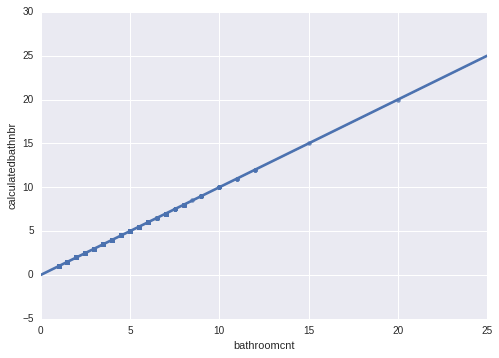

In [146]:
sns.regplot('bathroomcnt', 'calculatedbathnbr', data=x_train)

In [640]:
categorical_data = categorical_data.drop('assessmentyear', axis = 1)

In [641]:
categorical_data = categorical_data.drop('yearbuilt', axis = 1)

In [642]:
cat_dummies = pd.get_dummies(categorical_data)

In [702]:
cat_dummies.corr()

,buildingqualitytypeid_1,buildingqualitytypeid_10,buildingqualitytypeid_11,buildingqualitytypeid_12,buildingqualitytypeid_4,buildingqualitytypeid_6,buildingqualitytypeid_7,buildingqualitytypeid_8,fips_6037,fips_6059,...,regionidcity_56780,regionidcity_6021,regionidcity_6285,regionidcity_6395,regionidcity_6822,regionidcity_8384,regionidcity_9840,regionidcounty_1286,regionidcounty_2061,regionidcounty_3101
buildingqualitytypeid_1,1.000000,-0.022071,-0.000573,-0.006252,-0.102975,-0.000810,-0.258148,-0.001281,0.126398,-0.104927,...,0.011961,-0.009279,-0.000573,-0.007296,0.025488,-0.011099,0.007887,-0.104927,-0.050634,0.126398
buildingqualitytypeid_10,-0.022071,1.000000,-0.000424,-0.004632,-0.076291,-0.000600,-0.191254,-0.000949,0.093645,-0.077737,...,0.018423,-0.007687,-0.000424,-0.005406,0.030228,-0.008223,0.009995,-0.077737,-0.037513,0.093645
buildingqualitytypeid_11,-0.000573,-0.000424,1.000000,-0.000120,-0.001980,-0.000016,-0.004963,-0.000025,0.002430,-0.002017,...,-0.000081,-0.000199,-0.000011,-0.000140,-0.000054,-0.000213,-0.000187,-0.002017,-0.000974,0.002430
buildingqualitytypeid_12,-0.006252,-0.004632,-0.000120,1.000000,-0.021612,-0.000170,-0.054178,-0.000269,0.026527,-0.022021,...,-0.000884,-0.002178,-0.000120,-0.001531,0.018138,-0.002329,-0.002036,-0.022021,-0.010627,0.026527
buildingqualitytypeid_4,-0.102975,-0.076291,-0.001980,-0.021612,1.000000,-0.002800,-0.892341,-0.004427,0.436921,-0.362701,...,0.005979,0.023464,-0.001980,0.006211,0.005696,-0.038367,0.062498,-0.362701,-0.175025,0.436921
buildingqualitytypeid_6,-0.000810,-0.000600,-0.000016,-0.000170,-0.002800,1.000000,-0.007019,-0.000035,0.003437,-0.002853,...,-0.000114,-0.000282,-0.000016,-0.000198,-0.000076,-0.000302,-0.000264,-0.002853,-0.001377,0.003437
buildingqualitytypeid_7,-0.258148,-0.191254,-0.004963,-0.054178,-0.892341,-0.007019,1.000000,-0.011098,-0.489635,0.406459,...,-0.014975,-0.016703,0.002219,-0.001668,-0.024318,0.042996,-0.064928,0.406459,0.196142,-0.489635
buildingqualitytypeid_8,-0.001281,-0.000949,-0.000025,-0.000269,-0.004427,-0.000035,-0.011098,1.000000,0.005434,-0.004511,...,-0.000181,-0.000446,-0.000025,-0.000314,-0.000121,-0.000477,-0.000417,-0.004511,-0.002177,0.005434
fips_6037,0.126398,0.093645,0.002430,0.026527,0.436921,0.003437,-0.489635,0.005434,1.000000,-0.830128,...,0.017863,0.044024,-0.004531,0.030959,0.011907,-0.087813,0.040750,-0.830128,-0.400588,1.000000
fips_6059,-0.104927,-0.077737,-0.002017,-0.022021,-0.362701,-0.002853,0.406459,-0.004511,-0.830128,1.000000,...,-0.014829,-0.036546,0.005459,-0.025700,-0.009884,0.105782,-0.034170,1.000000,-0.178342,-0.830128


In [643]:
#Concatenate numerical and dummied data frames
combined = pd.concat([cat_dummies, numeric_data], axis=1)

In [679]:
train_y = df_train.logerror.values
train_x = combined

In [681]:
split = int(x_train.shape[0] * 0.6)
train_x, train_y, val_x, val_y = train_x[:split], train_y[:split], train_x[split:], train_y[split:]

In [682]:
clf = LinearRegression()

In [683]:
clf.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [684]:
predict = clf.predict(val_x)

In [507]:
clf = LogisticRegression(C=1e5)

In [ ]:
clf.fit(train_x, train_y)

In [651]:
coefs = clf.coef_.reshape(234,)
colnames = train_x.columns.values

In [652]:
coefs = pd.Series(coefs)
coefs.index = colnames

In [ ]:
coefs.sort_values(ascending=False)

In [ ]:
train_x.head()

In [667]:
predicted = clf.predict(val_x)

array([ 0.11826567,  0.09454873,  0.06603839, ...,  0.07043933,
        0.11607577,  0.07884656])

(-0.5, 0.5)

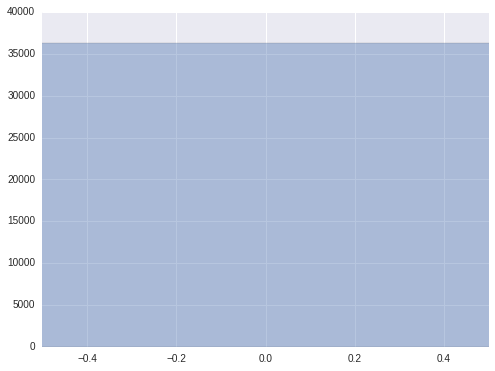

In [698]:
sns.distplot(predicted - val_y, kde=False, bins=100)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)
plt.xlim(-0.5, 0.5)

In [695]:
predicted - val_y

array([ 0.13946567,  0.12704873,  0.12793839, ...,  0.01023933,
       -0.30462423, -0.05825344])

In [668]:
mse = np.mean((predicted - val_y)**2)

In [669]:
mse

1848.6702542437583

In [670]:
r2_score(predicted, val_y)

-2.5720270115270338e-05

In [311]:
from sklearn.metrics import accuracy_score

In [445]:
accuracy_score(val_y, predicted)

0.57081899518238133

In [43]:
# Make a separate column for month and year
transactions['yymm'] = transactions['transactiondate'].apply(lambda x: x[0:7])
transactions['abslogerror'] = transactions['logerror'].apply(lambda x: abs(x))
transactions.transactiondate[10][5:7]
transactions['month'] = transactions['transactiondate'].apply(lambda x: x[5:7])

(-0.5, 0.5)

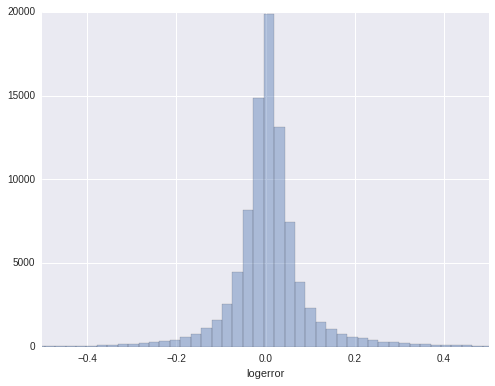

In [42]:


# Distribution of log error
sns.distplot(transactions.logerror, kde=False, bins=400)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)
plt.xlim(-0.5, 0.5)

(0, 0.5)

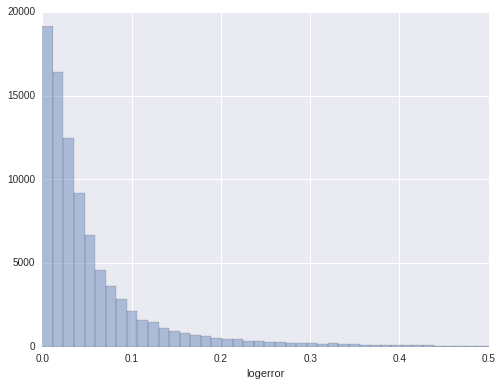

In [35]:
# Distribution of absolute log error
sns.distplot(abs(transactions.logerror), kde=False, bins=400)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)
plt.xlim(0, 0.5)

In [ ]:
#Change in logerror by year
abserr = joined.groupby(['build_year']).logerror.mean().sort_index()
plt.figure()
ax = plt.axes()
ax.plot(abserr.index, abserr.values)
plt.xticks(np.arange(min(years.index), max(years.index)+1, 20))
plt.show()
#see if changed this line that much

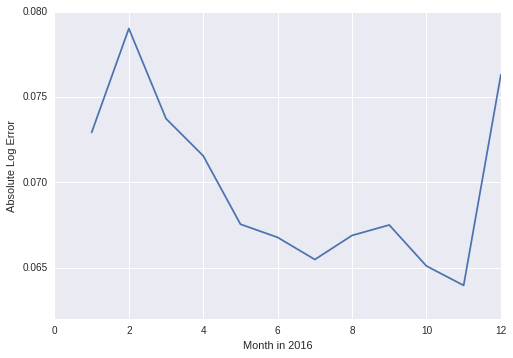

In [46]:
#Change in Absolute Log Error over the months in 2016 transactions
over_time = transactions.groupby(['month']).abslogerror.mean().sort_index()
over_time

plt.figure()
ax = plt.axes()

ax.plot(over_time.index, over_time.values)
plt.xlabel('Month in 2016')
plt.ylabel('Absolute Log Error')
plt.show()